In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('images_dataframe.csv', index_col=0)
df.tags_list = df.tags_list.astype(object)
df

,category,gallery_name,channel,models,gallery_categories,tags_list,rating,views
0,blonde,blonde-babe-jana-d-strips-at-the-office-and-po...,Only All Sites PicsOnly Tease Pics,['Jana D'],"['Panties', 'Stockings', 'Uniform', 'High Heel...","['Upskirt Panties', 'Office Upskirt', 'Teen Up...",100%,"90,351"
1,blonde,sweet-blonde-spinner-heather-shows-her-tits-as...,FTV Girls Pics,['Heather'],"['Fetish', 'Petite', 'Blonde', 'Couple', 'Pret...","['Hot Naked', 'Women', 'Blonde Babe']",100%,"169,041"
2,blonde,blonde-glamour-babe-fay-love-freeing-tiny-teen...,Met Art Pics,['Fay Love'],"['Cute', 'Teen', 'Blonde', 'Beautiful', 'Outdo...","['Blonde Teen', 'Blonde Ass', 'Beautiful Teen'...",95%,"155,940"
3,blonde,met-art-naomi-kiss-44521957,Met Art Pics,['Naomi Kiss'],"['Petite', 'Curly', 'Natural Tits', 'Blonde', ...","['Hot Naked', 'Girls', 'Sexy Petite', 'Topless...",96%,"39,620"
4,blonde,beautiful-pornstar-samantha-saint-posing-in-he...,Puba Network Pics,['Samantha Saint'],"['Blonde', 'Pornstar', 'Clothed', 'Lingerie', ...","['Hot Naked', 'Women']",70%,"58,609"
...,...,...,...,...,...,...,...,...
82583,yoga-pants,gorgeous-blonde-hazel-max-goes-topless-while-w...,Skin Tight Glamour Pics,['Hazel Max'],"['Yoga Pants', 'Ass', 'Non Nude', 'PAWG', 'Big...","['Leggings', 'Yoga Pants', 'Ass', 'Blonde Yoga...",97%,"35,386"
82584,yoga-pants,blonde-uk-secretary-aston-wilde-uncovers-her-t...,Only All Sites PicsOnly Secretaries Pics,['Aston Wilde'],"['Yoga Pants', 'Office', 'Secretary', 'Pantyho...","['Leggings', 'Pantyhose Feet', 'Yoga Pants', '...",100%,"31,938"
82585,yoga-pants,small-breasted-female-drools-before-sucking-a-...,The Dick Suckers Pics,['Sheena Shaw'],"['MILF', 'Yoga Pants', 'Leather', 'High Heels'...","['MILF PussyMILF Ass', 'Leggings', 'MILF Yoga'...",93%,"1,169,535"
82586,yoga-pants,sexy-teen-sakari-rios-strips-naked-rubs-her-me...,Watch 4 Beauty Pics,['Sakari Rios'],"['Latina', 'Yoga Pants', 'Ass', 'Clothed', 'Sp...","['Latina Pussy', 'Latina Spread', 'Leggings']",100%,"48,728"


In [30]:
df.iloc[34142]

category                                                       homemade
gallery_name          sexy-amateur-gets-a-thorough-anal-pounding-in-...
channel                                             Love Home Porn Pics
models                                               ['Alice Campbell']
gallery_categories    ['Homemade', 'Cum In', 'Mouth', 'Amateur', 'An...
tags_list             ['Amateur Homemade', 'Homemade Pussy', 'Cum Sw...
rating                                                              96%
views                                                            61,069
Name: 34142, dtype: object

In [22]:
# Flatten the list of tags
all_tags = [ast.literal_eval(sublist) for sublist in df['tags_list'].values if pd.isna(sublist) == False]
merged_list = [item for sublist in all_tags for item in sublist]
tag_counts = Counter(merged_list)
tag_counts

Counter({'Big Tits': 22694,
         'Tits': 20472,
         'Pussy': 15490,
         'Women': 9414,
         'Hot Naked': 8781,
         'Teen': 5887,
         'Big Ass': 5175,
         'Fuck': 4098,
         'Short Hair': 3381,
         'Panties': 3210,
         'Bent Over': 3052,
         'Cum On': 2761,
         'Ass': 2735,
         'Spread': 2177,
         'Close Up': 2097,
         'High Heels': 2096,
         'Anal': 2033,
         'Hairy Teen': 1926,
         'Petite Teen': 1902,
         'Girls': 1896,
         'Small Tits': 1805,
         'Lingerie': 1758,
         'Babe': 1737,
         'Hairy Pussy': 1735,
         'Amateur Teen': 1722,
         'Perfect Ass': 1665,
         'Vagina': 1662,
         'Pants': 1662,
         'Tight Ass': 1637,
         'Skinny Teen': 1584,
         'Big Natural': 1579,
         'Teen Pussy': 1569,
         'Open Pussy': 1521,
         'Latina': 1516,
         'Pussy Ass': 1482,
         'Ass Spread': 1475,
         'Spread Legs': 1458,
     

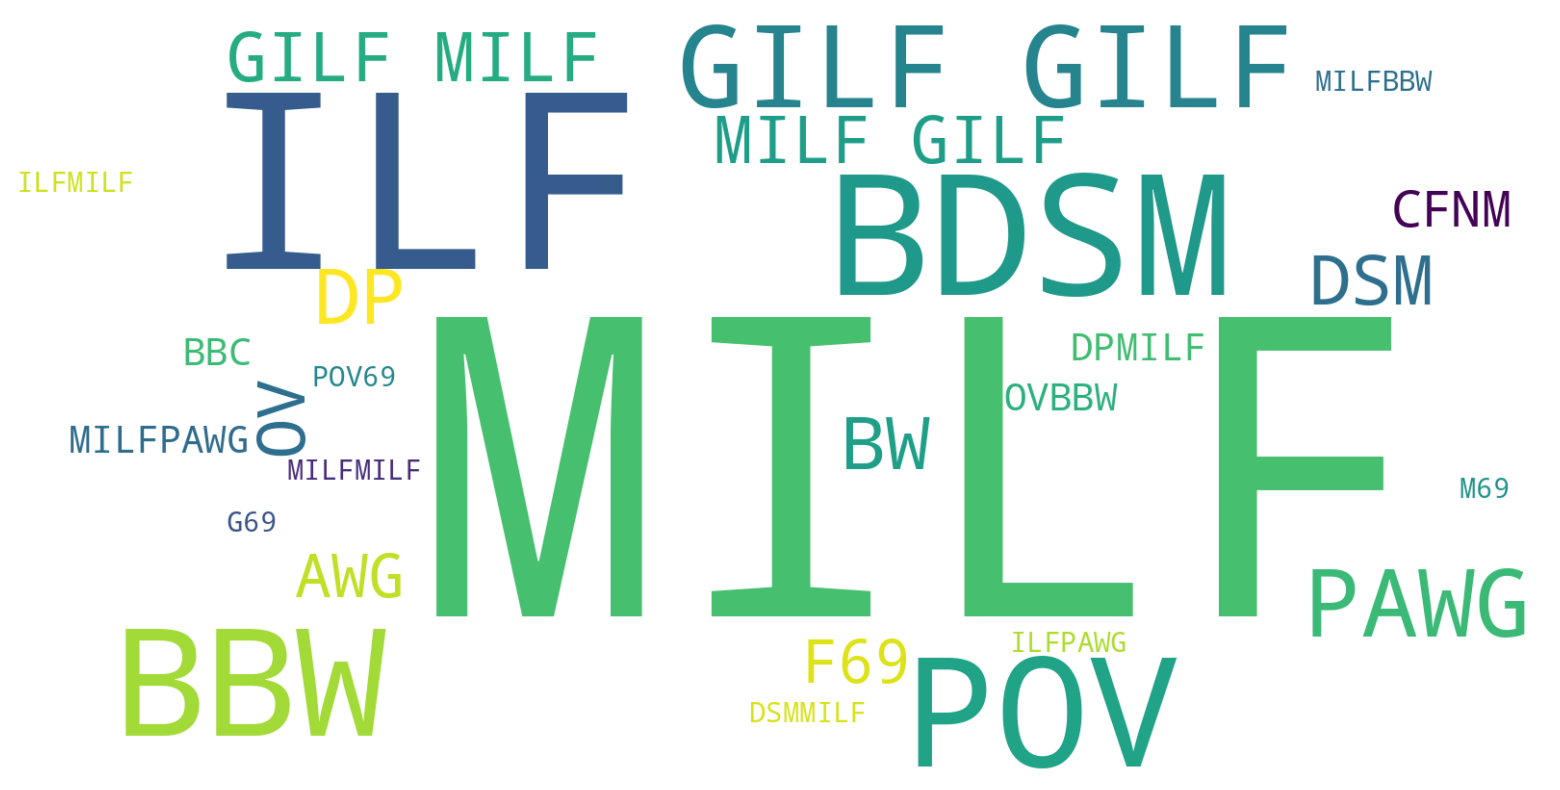

In [98]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800 * 2, height=400 * 2, background_color='white').generate(
    " ".join(w for w in merged_list if w.isupper()))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [99]:
set(w for w in merged_list if w.isupper())

{'AWG',
 'BBW',
 'BBW BBC',
 'BBW BDSM',
 'BBW MILF',
 'BBW PAWG',
 'BBW POV',
 'BDSM',
 'BW',
 'CFNM MILF',
 'DP',
 'DPMILF DP',
 'DSM',
 'DSMMILF BDSM',
 'F69',
 'G69',
 'GILF',
 'ILF',
 'ILFMILF BDSM',
 'ILFPAWG MILF',
 'M69',
 'MILF',
 'MILF BDSM',
 'MILF DP',
 'MILF POV',
 'MILFBBW MILF',
 'MILFMILF BDSM',
 'MILFPAWG MILF',
 'OV',
 'OVBBW MILF',
 'OVBBW POV',
 'PAWG MILF',
 'POV',
 'POV69'}

In [41]:
import re

In [135]:
acronyms = ['69', 'BBC', 'BBW', 'BDSM', 'CFNM', 'DP', 'GILF', 'MILF', 'PAWG', 'POV']
input_str = "MILF AmateurHomemadeCum In MouthAmateurMature MILFBritish MILFAnalBlowjobDoggy StyleFacialPanties69CumshotRealityPAWGBDSM"

In [139]:
def process_string(input_string):
    word_list = re.findall('[A-Z][^A-Z]*', input_string)

    joined_words = []
    temp_word = ""
    for word in word_list:
        if word.endswith(" "):
            temp_word += word
        else:
            if temp_word:
                joined_words.append(temp_word + word)
                temp_word = ""
            else:
                joined_words.append(word)

    final_words = []
    temp_word = ""
    for word in joined_words:
        if len(word) == 1 and word.isupper():
            temp_word += word
        elif len(word) > 1 and word[1] == " ":
            temp_word += word
        elif len(word) > 1 and word[-2] == " ":
            final_words.append(temp_word)
            temp_word = ""
            temp_word += word

        else:
            if temp_word:
                final_words.append(temp_word)
                temp_word = ""
            final_words.append(word)
    if temp_word:
        final_words.append(temp_word)

    word_list = [w for w in final_words if w != ""]
    
    new_list = []
    for word in word_list:
        match = re.match(r"([a-zA-Z]+)([0-9]+)", word)
        if match:
            new_list.append(match.group(1))
            new_list.append(int(match.group(2)))
        else:
            new_list.append(word)
    return new_list


def split_and_verify_acronyms(words_list, acronyms):
    out = []

    for word in words_list:
        word = str(word)
        if word.isupper():
            for acronym in acronyms:
                if acronym in word:
                    out.append(acronym)
                    word = word.replace(acronym, "")
        out.append(word)

    return [w for w in out if w != ""]


words_list = process_string(input_str)
words_list = split_and_verify_acronyms(words_list, acronyms)
words_list

['MILF Amateur',
 'Homemade',
 'Cum In Mouth',
 'Amateur',
 'Mature MILF',
 'British MILF',
 'Anal',
 'Blowjob',
 'Doggy Style',
 'Facial',
 'Panties',
 '69',
 'Cumshot',
 'Reality',
 'BDSM',
 'PAWG']